<a href="https://colab.research.google.com/github/Justin-Jonany/IndoFoodNet/blob/main/3_model_training_efficientnetv2_b1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IndoFoodNet
IndoFoodNet aims to create a neural networks model that correctly classifies images of 9 differet Padang food. The dataset is taken from https://www.kaggle.com/datasets/faldoae/padangfood.

</br>

This notebook aims to create models to classify images into the correct labels based on **EfficientNetV2B1**

## Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import os
import pandas as pd

## Helper Functions

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
  plt.show()



def compare_historys(original_history, new_history, initial_epochs):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## Load Data

In [ ]:
path = '/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/processed_data/b1_'
train_data = tf.data.Dataset.load(path + 'train_data')
test_data = tf.data.Dataset.load(path + 'test_data')
val_data = tf.data.Dataset.load(path + 'val_data')

In [ ]:
train_data.element_spec

(TensorSpec(shape=(None, 240, 240, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))

In [ ]:
train_dir = '/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/splitted_data/train/'
class_names = os.listdir(train_dir)

## Creating Callbacks

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0.005,
                                                  patience=4)

# Set checkpoint path
checkpoint_path = 'checkpoints/checkpoint'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq='epoch', # Save every epoch
                                                         verbose=1)



## Setup mixed prevision training

In [ ]:
# Turn on mixed prevision training
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision
mixed_precision.global_policy()

<Policy "mixed_float16">

## Base Model

In [ ]:
input_shape = (240, 240, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name='input_layer')

metrics = [tf.keras.metrics.F1Score(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           'accuracy'
          ]

In [ ]:
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model_0 = tf.keras.Model(inputs, outputs)


# Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=metrics
                )

In [ ]:
history_0 = model_0.fit(train_data,
                        epochs=50,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        callbacks=[early_stopping]
                        )

Epoch 1/50
21/21 [==============================] - 13s 160ms/step - loss: 1.8580 - f1_score: 0.4315 - precision_1: 1.0000 - recall_1: 0.0031 - accuracy: 0.4259 - val_loss: 1.4285 - val_f1_score: 0.6975 - val_precision_1: 1.0000 - val_recall_1: 0.0333 - val_accuracy: 0.7000
Epoch 2/50
21/21 [==============================] - 2s 71ms/step - loss: 1.0981 - f1_score: 0.8200 - precision_1: 1.0000 - recall_1: 0.2068 - accuracy: 0.8210 - val_loss: 0.9951 - val_f1_score: 0.8109 - val_precision_1: 0.9667 - val_recall_1: 0.3222 - val_accuracy: 0.8111
Epoch 3/50
21/21 [==============================] - 2s 88ms/step - loss: 0.7445 - f1_score: 0.9010 - precision_1: 0.9823 - recall_1: 0.5139 - accuracy: 0.9012 - val_loss: 0.7845 - val_f1_score: 0.8454 - val_precision_1: 0.9592 - val_recall_1: 0.5222 - val_accuracy: 0.8444
Epoch 4/50
21/21 [==============================] - 2s 91ms/step - loss: 0.5647 - f1_score: 0.9272 - precision_1: 0.9805 - recall_1: 0.6991 - accuracy: 0.9275 - val_loss: 0.6687 -

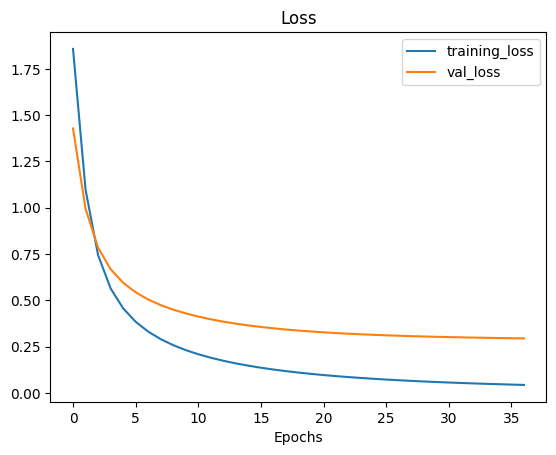

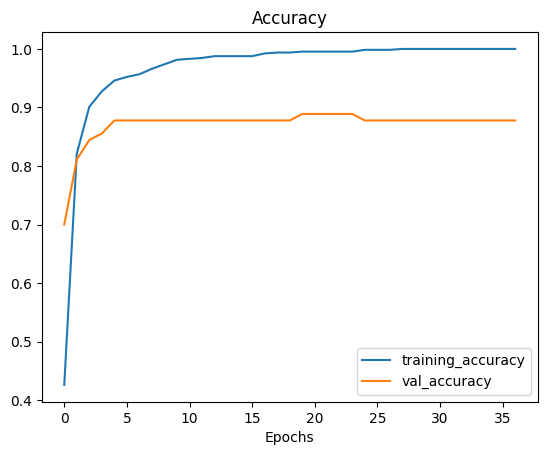

In [ ]:
plot_loss_curves(history_0)

It seems our model is overfitting

In [ ]:
model_0.evaluate(val_data)

3/3 [==============================] - 0s 64ms/step - loss: 0.2946 - f1_score: 0.8786 - precision_1: 0.9286 - recall_1: 0.8667 - accuracy: 0.8778


[0.2945799231529236,
 array([0.84210527, 0.95238096, 0.9       , 0.88888896, 0.7826087 ,
        0.84210527, 0.8000001 , 0.9473684 , 0.95238096], dtype=float32),
 0.9285714030265808,
 0.8666666746139526,
 0.8777777552604675]

In [ ]:
model_0.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b1/model_0')

## Model 1: Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name='data_augmentation')

In [ ]:
x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=metrics,
                )

In [ ]:
history_1 = model_1.fit(train_data,
                        epochs=25,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        callbacks=[early_stopping]
                        )

Epoch 1/25
21/21 [==============================] - 12s 235ms/step - loss: 1.7996 - f1_score: 0.5072 - precision_1: 0.9318 - recall_1: 0.1111 - accuracy: 0.4552 - val_loss: 1.3427 - val_f1_score: 0.7053 - val_precision_1: 1.0000 - val_recall_1: 0.0333 - val_accuracy: 0.7111
Epoch 2/25
21/21 [==============================] - 2s 74ms/step - loss: 1.0603 - f1_score: 0.8415 - precision_1: 1.0000 - recall_1: 0.2006 - accuracy: 0.8426 - val_loss: 0.9402 - val_f1_score: 0.8243 - val_precision_1: 1.0000 - val_recall_1: 0.3556 - val_accuracy: 0.8222
Epoch 3/25
21/21 [==============================] - 2s 68ms/step - loss: 0.7190 - f1_score: 0.9072 - precision_1: 0.9915 - recall_1: 0.5370 - accuracy: 0.9074 - val_loss: 0.7421 - val_f1_score: 0.8338 - val_precision_1: 0.9800 - val_recall_1: 0.5444 - val_accuracy: 0.8333
Epoch 4/25
21/21 [==============================] - 1s 68ms/step - loss: 0.5453 - f1_score: 0.9274 - precision_1: 0.9791 - recall_1: 0.7222 - accuracy: 0.9275 - val_loss: 0.6321 -

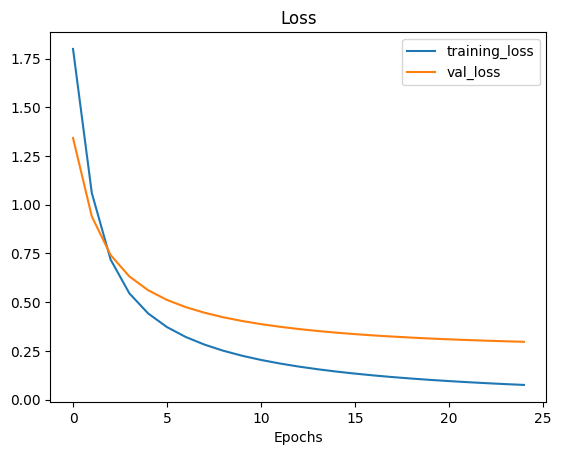

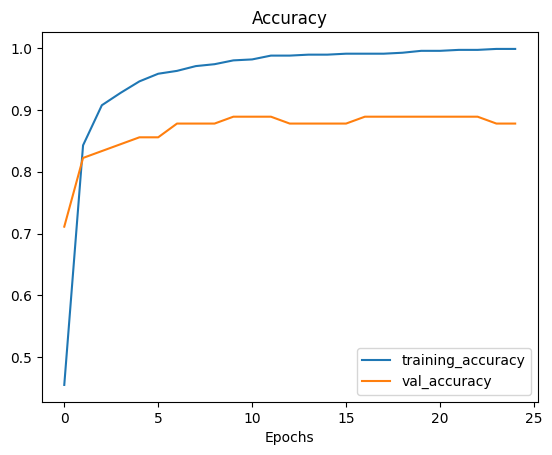

In [ ]:
plot_loss_curves(history_1)

In [ ]:
model_1.evaluate(val_data)

3/3 [==============================] - 0s 50ms/step - loss: 0.2967 - f1_score: 0.8798 - precision_1: 0.9398 - recall_1: 0.8667 - accuracy: 0.8778


[0.29669150710105896,
 array([0.88888896, 0.95238096, 0.84210527, 0.9473684 , 0.81818175,
        0.84210527, 0.72727275, 0.9473684 , 0.95238096], dtype=float32),
 0.9397590160369873,
 0.8666666746139526,
 0.8777777552604675]

In [ ]:
model_0.evaluate(val_data)

3/3 [==============================] - 0s 51ms/step - loss: 0.2946 - f1_score: 0.8786 - precision_1: 0.9286 - recall_1: 0.8667 - accuracy: 0.8778


[0.2945799231529236,
 array([0.84210527, 0.95238096, 0.9       , 0.88888896, 0.7826087 ,
        0.84210527, 0.8000001 , 0.9473684 , 0.95238096], dtype=float32),
 0.9285714030265808,
 0.8666666746139526,
 0.8777777552604675]

In [ ]:
model_1.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b1/model_1')

Data augmentation seems to improve f1-score very slightly, and increase loss. So, let's fine tune without data augmentation

## Model 2: No Data Augmentation and Fine Tuning


Let's unfreeze the first 10 layers for this model

In [ ]:
model_2 = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b1/model_0')

In [ ]:
model_2.layers

In [ ]:
model_2.layers[1].trainable = True
for layer in model_2.layers[1].layers[:-10]:
  layer.trainable = False

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=metrics)

In [ ]:
fine_tune_epochs = history_0.epoch[-1] + 20
checkpoint_callback.filepath = 'checkpoint/model_2'
history_2 = model_2.fit(train_data,
                        epochs=fine_tune_epochs,
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        initial_epoch=history_0.epoch[-1],
                        callbacks=[early_stopping,
                                   checkpoint_callback]
                        )

Epoch 37/56
20/21 [===========================>..] - ETA: 0s - loss: 0.0310 - f1_score: 0.9849 - precision_1: 0.9917 - recall_1: 0.9836 - accuracy: 1.0000
Epoch 37: val_loss improved from inf to 0.28345, saving model to checkpoint/model_2
21/21 [==============================] - 15s 225ms/step - loss: 0.0307 - f1_score: 0.9851 - precision_1: 0.9918 - recall_1: 0.9837 - accuracy: 1.0000 - val_loss: 0.2834 - val_f1_score: 0.8896 - val_precision_1: 0.9080 - val_recall_1: 0.8778 - val_accuracy: 0.8889
Epoch 38/56
21/21 [==============================] - ETA: 0s - loss: 0.0125 - f1_score: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - accuracy: 1.0000
Epoch 38: val_loss did not improve from 0.28345
21/21 [==============================] - 2s 74ms/step - loss: 0.0125 - f1_score: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - accuracy: 1.0000 - val_loss: 0.3104 - val_f1_score: 0.9013 - val_precision_1: 0.8989 - val_recall_1: 0.8889 - val_accuracy: 0.9000
Epoch 39/56
21/21 [=============

In [ ]:
model_2.evaluate(val_data)

3/3 [==============================] - 0s 76ms/step - loss: 0.3286 - f1_score: 0.9013 - precision_1: 0.9000 - recall_1: 0.9000 - accuracy: 0.9000


[0.32855796813964844,
 array([0.9       , 0.95238096, 0.9473684 , 0.88888896, 0.8333334 ,
        0.84210527, 0.8000001 , 0.9473684 , 1.        ], dtype=float32),
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421]

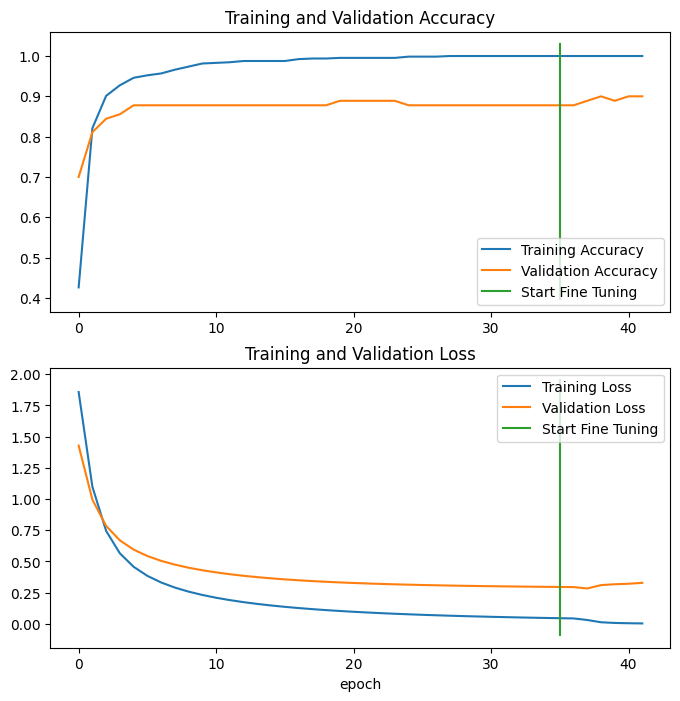

In [ ]:
compare_historys(history_0, history_2, history_0.epoch[-1])

It makes a slight improvement :))

In [ ]:
model_2.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b1/model_2')

## Model 3: No Data Augmentation and Fine Tuning 2
fine-tuning 20 layers

In [ ]:
model_3 = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b1/model_0')

In [ ]:
model_3.layers[1].trainable = True
for layer in model_3.layers[1].layers[:-20]:
  layer.trainable = False

model_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=metrics)

In [ ]:
fine_tune_epochs = history_0.epoch[-1] + 20

checkpoint_callback.filepath = 'checkpoint/model_3'

history_3 = model_3.fit(train_data,
                        epochs=fine_tune_epochs,
                        validation_data=val_data,
                        validation_steps=len(val_data),
                        initial_epoch=history_0.epoch[-1],
                        callbacks=[early_stopping, checkpoint_callback]
                        )

Epoch 37/56
21/21 [==============================] - ETA: 0s - loss: 0.0721 - f1_score: 0.9702 - precision_1: 0.9740 - recall_1: 0.9648 - accuracy: 0.9799
Epoch 37: val_loss did not improve from 0.28345
21/21 [==============================] - 49s 224ms/step - loss: 0.0721 - f1_score: 0.9702 - precision_1: 0.9740 - recall_1: 0.9648 - accuracy: 0.9799 - val_loss: 0.3754 - val_f1_score: 0.8678 - val_precision_1: 0.8736 - val_recall_1: 0.8444 - val_accuracy: 0.8667
Epoch 38/56
21/21 [==============================] - ETA: 0s - loss: 0.0135 - f1_score: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - accuracy: 1.0000
Epoch 38: val_loss did not improve from 0.28345
21/21 [==============================] - 5s 205ms/step - loss: 0.0135 - f1_score: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - accuracy: 1.0000 - val_loss: 0.2997 - val_f1_score: 0.8767 - val_precision_1: 0.8966 - val_recall_1: 0.8667 - val_accuracy: 0.8778
Epoch 39/56
21/21 [==============================] - ETA: 0s - loss

In [ ]:
model_3.evaluate(val_data)

3/3 [==============================] - 0s 47ms/step - loss: 0.3489 - f1_score: 0.9007 - precision_1: 0.8989 - recall_1: 0.8889 - accuracy: 0.9000


[0.3489108681678772,
 array([0.9473684 , 0.95238096, 0.9       , 0.9       , 0.8333334 ,
        0.88888896, 0.73684216, 0.9473684 , 1.        ], dtype=float32),
 0.898876428604126,
 0.8888888955116272,
 0.8999999761581421]

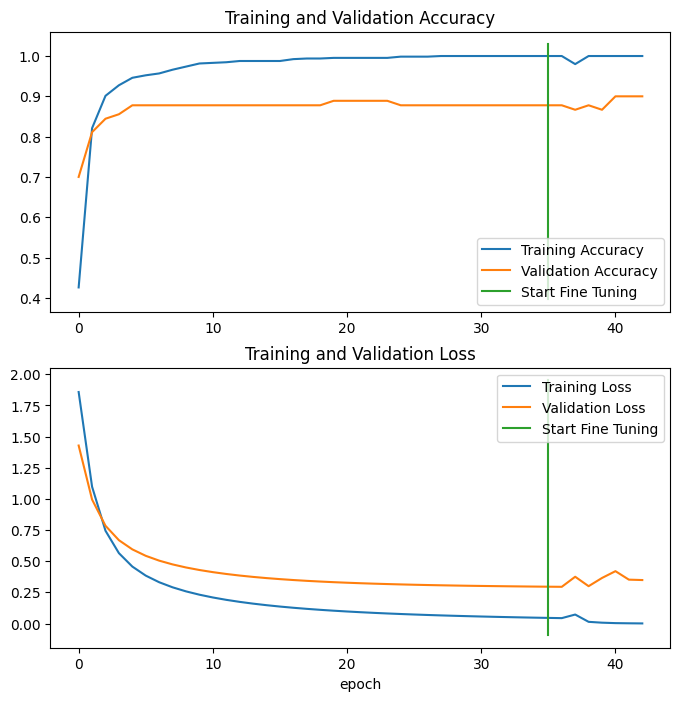

In [ ]:
compare_historys(history_0, history_3, history_0.epoch[-1])

In [ ]:
model_3.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/efficientnetv2b1/model_3')

It seems our model is no longer improving that much, so we will conclude this notebook on model training on **EfficientNetV2B1**

In [ ]:
model_0_scores = model_0.evaluate(val_data)
model_1_scores = model_1.evaluate(val_data)
model_2_scores = model_2.evaluate(val_data)
model_3_scores = model_3.evaluate(val_data)

print(f'model_0:\n loss: {model_0_scores[0]} \n accuracy: {model_0_scores[4]}')
print(f'model_1:\n loss: {model_1_scores[0]} \n accuracy: {model_1_scores[4]}')
print(f'model_2:\n loss: {model_2_scores[0]} \n accuracy: {model_2_scores[4]}')
print(f'model_3:\n loss: {model_3_scores[0]} \n accuracy: {model_3_scores[4]}')

3/3 [==============================] - 0s 53ms/step - loss: 0.3489 - f1_score: 0.9007 - precision_1: 0.8989 - recall_1: 0.8889 - accuracy: 0.9000
model_0:
 loss: 0.2945799231529236 
 accuracy: 0.8777777552604675
model_1:
 loss: 0.29669150710105896 
 accuracy: 0.8777777552604675
model_2:
 loss: 0.32855796813964844 
 accuracy: 0.8999999761581421
model_3:
 loss: 0.3489108681678772 
 accuracy: 0.8999999761581421


In [ ]:
model_0_scores[1] = model_0_scores[1].mean()
model_1_scores[1] = model_1_scores[1].mean()
model_2_scores[1] = model_2_scores[1].mean()
model_3_scores[1] = model_3_scores[1].mean()

loss = pd.DataFrame({'model_0': model_0_scores,
                         'model_1': model_1_scores,
                         'model_2': model_2_scores,
                         'model_3': model_3_scores,
                         }, index=['loss', 'f1-score', 'precision', 'recall', 'accuracy'])
loss = loss.T
loss

,loss,f1-score,precision,recall,accuracy
model_0,0.294580,0.878649,0.928571,0.866667,0.877778
model_1,0.296692,0.879784,0.939759,0.866667,0.877778
model_2,0.328558,0.901272,0.900000,0.900000,0.900000
model_3,0.348911,0.900687,0.898876,0.888889,0.900000


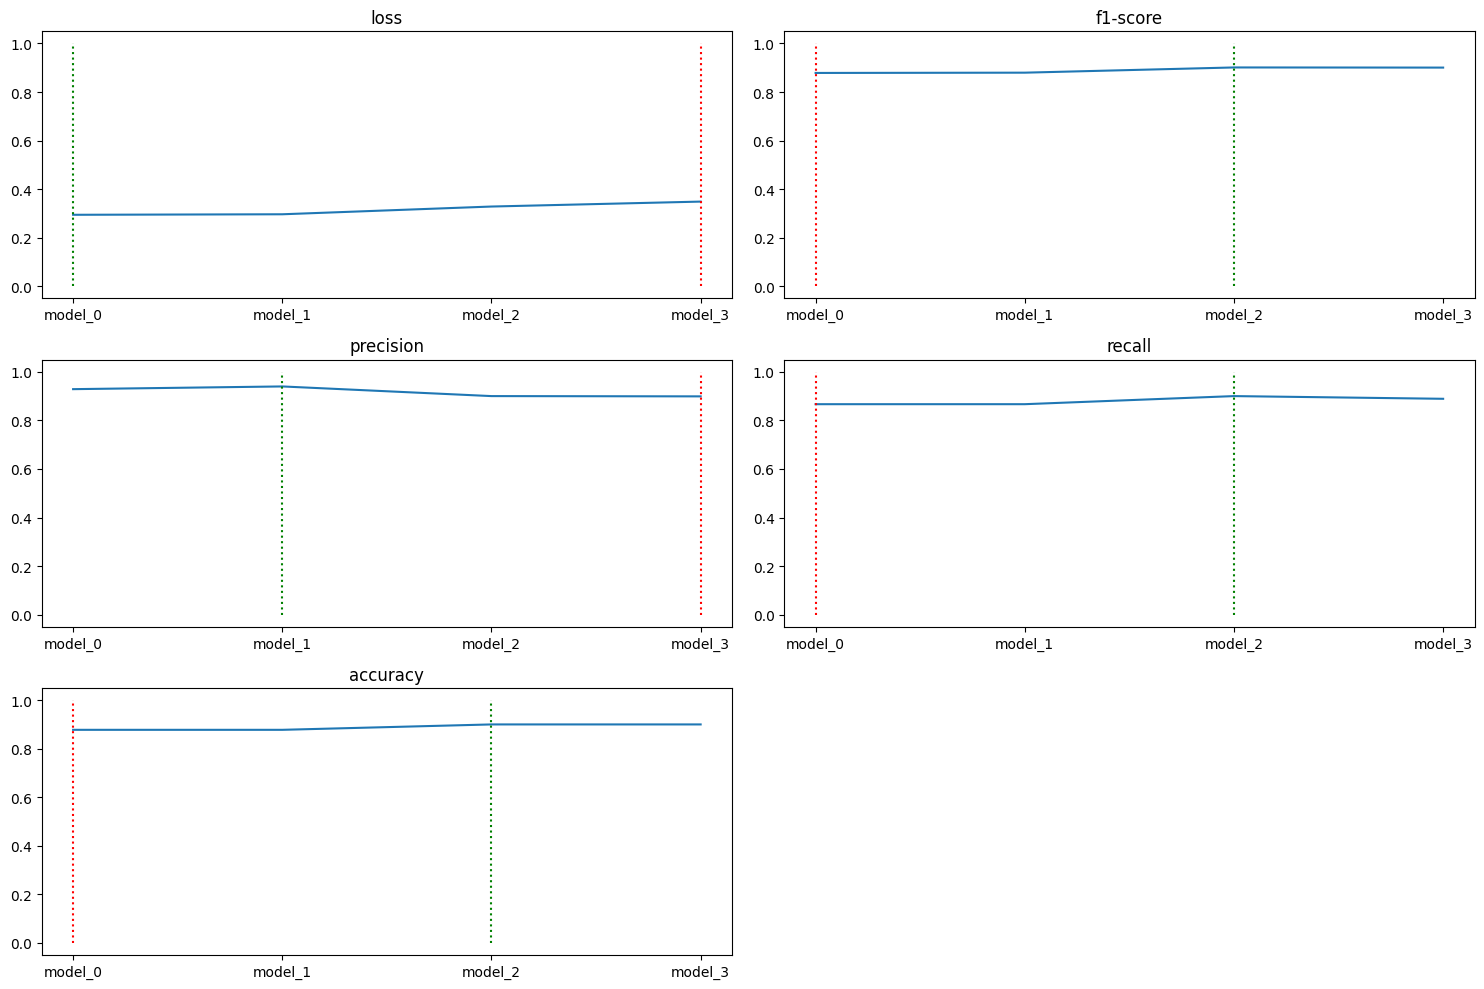

In [ ]:
fig = plt.figure(figsize=(15, 10))
for i, index in enumerate(loss.columns):
  plt.subplot(3, 2, 1 + i)
  plt.plot(loss[index])
  plt.title(index)
  if index == 'loss':
    plt.vlines(loss.index[loss[index].argmax()], 0, 1, color='red', linestyles='dotted')
    plt.vlines(loss.index[loss[index].argmin()], 0, 1, color='green', linestyles='dotted')
  else:
    plt.vlines(loss.index[loss[index].argmax()], 0, 1, color='green', linestyles='dotted')
    plt.vlines(loss.index[loss[index].argmin()], 0, 1, color='red', linestyles='dotted')

fig.tight_layout()

It's hard to decide whether to go for better loss or better f1-score, but to follow the other model trainings, loss will be looked on. So, model_0 is the best model

In [ ]:
model_0.save('/content/drive/MyDrive/ColabNotebooks/projects/IndoFoodNet/models/best_model_per_version/efficientnetv2b1_fine_tuned')